In [26]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [29]:
tmdb_df = pd.read_csv('/content/drive/MyDrive/DATA/tmdb.csv')
links_df = pd.read_csv('/content/drive/MyDrive/DATA/links.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/DATA/ratings.csv')
movies_df = pd.read_csv('/content/drive/MyDrive/DATA/movies.csv')
tags_df = pd.read_csv('/content/drive/MyDrive/DATA/tags.csv')

In [30]:
tmdb_df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


In [31]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [32]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [33]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [34]:
tags_df.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


In [35]:
sns.set_style("whitegrid")

In [36]:
links_df['tmdbId'] = pd.to_numeric(links_df['tmdbId'], errors='coerce')
if 'id' in tmdb_df.columns and 'tmdbId' not in tmdb_df.columns:
    tmdb_df.rename(columns={'id': 'tmdbId'}, inplace=True)
tmdb_df['tmdbId'] = pd.to_numeric(tmdb_df['tmdbId'], errors='coerce')

In [37]:
movies_with_links = movies_df.merge(links_df[['movieId', 'tmdbId']], on='movieId', how='left')
movies_final_df = movies_with_links.merge(tmdb_df[['tmdbId', 'poster_path']], on='tmdbId', how='left')

rated_movie_ids = ratings_df['movieId'].unique()
movies_final_df = movies_final_df[movies_final_df['movieId'].isin(rated_movie_ids)]
movies_final_df = movies_final_df.sort_values('movieId').reset_index(drop=True)
movie_ids = movies_final_df['movieId'].values

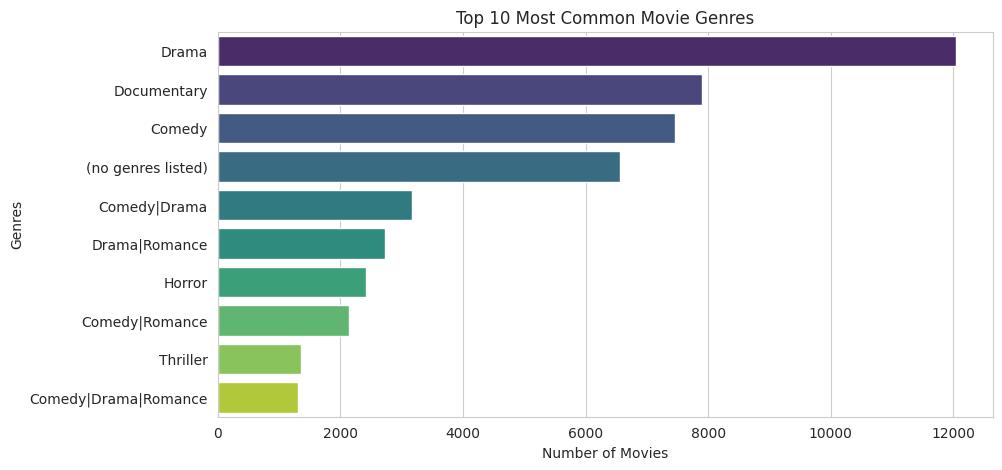

In [38]:
genre_counts = pd.Series(movies_final_df['genres'].explode()).value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=genre_counts.values[:10], y=genre_counts.index[:10], hue=genre_counts.index[:10], palette="viridis", legend=False)
plt.xlabel("Number of Movies")
plt.ylabel("Genres")
plt.title("Top 10 Most Common Movie Genres")
plt.show()

In [39]:
movies_final_df['genres'] = movies_final_df['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(movies_final_df['genres'])

In [40]:
movies_final_df.head()

,movieId,title,genres,tmdbId,poster_path
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",862.0,/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",8844.0,/vgpXmVaVyUL7GGiDeiK1mKEKzcX.jpg
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",15602.0,/1FSXpj5e8l4KH6nVFO5SPUeraOt.jpg
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",31357.0,/4wjGMwPsdlvi025ZqR4rXnFDvBz.jpg
4,5,Father of the Bride Part II (1995),[Comedy],11862.0,/rj4LBtwQ0uGrpBnCELr716Qo3mw.jpg


In [41]:
N_TAGS = 50
tag_counts = tags_df['tag'].value_counts()
top_tags = tag_counts.head(N_TAGS).index
movie_tag_counts = tags_df[tags_df['tag'].isin(top_tags)].groupby(['movieId', 'tag']).size().unstack(fill_value=0)
movie_tag_counts = movie_tag_counts.reindex(movie_ids).fillna(0).values
tfidf = TfidfTransformer()
tag_features = tfidf.fit_transform(movie_tag_counts).toarray()

In [42]:
movie_avg_ratings = ratings_df.groupby('movieId')['rating'].mean()
global_mean = ratings_df['rating'].mean()
avg_ratings = np.array([movie_avg_ratings.get(mid, global_mean) for mid in movie_ids]).reshape(-1, 1)
scaler_avg = StandardScaler()
avg_ratings_scaled = scaler_avg.fit_transform(avg_ratings)

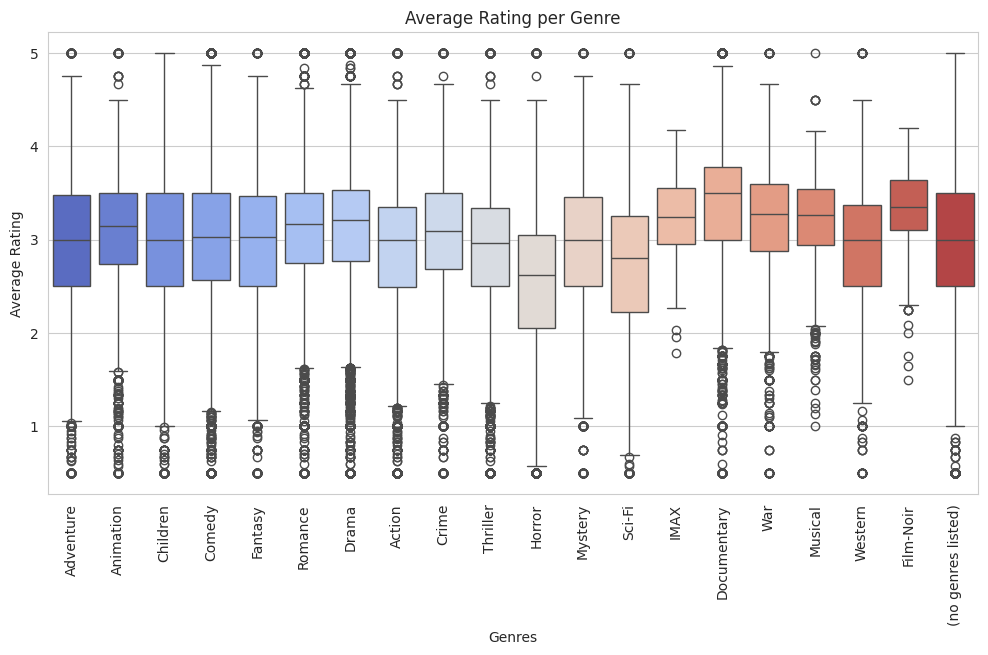

In [ ]:
genre_ratings = pd.DataFrame({'Genre': movies_final_df['genres'], 'Rating': avg_ratings.flatten()})
genre_ratings = genre_ratings.explode('Genre')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='Rating', data=genre_ratings, hue='Genre', palette='coolwarm', legend=False)
plt.xticks(rotation=90)
plt.xlabel("Genres")
plt.ylabel("Average Rating")
plt.title("Average Rating per Genre")
plt.show()

In [43]:
content_features = np.hstack([genre_features, tag_features, avg_ratings_scaled])

In [44]:
movie_id_to_idx = {mid: i for i, mid in enumerate(movie_ids)}
user_ids = ratings_df['userId'].unique()
user_id_to_idx = {uid: i for i, uid in enumerate(user_ids)}

rows = ratings_df['movieId'].map(movie_id_to_idx).dropna().astype(int)
cols = ratings_df['userId'].map(user_id_to_idx).dropna().astype(int)
data = ratings_df['rating'].values
ratings_matrix = csr_matrix((data, (rows, cols)), shape=(len(movie_ids), len(user_ids)))

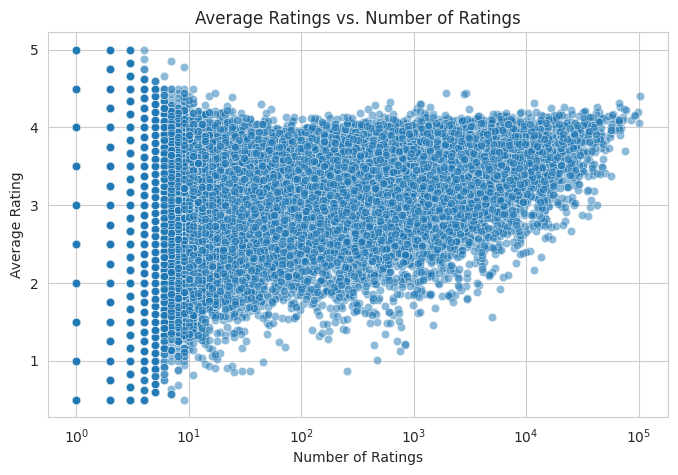

In [ ]:
avg_movie_ratings = ratings_df.groupby('movieId')['rating'].mean()
num_ratings_per_movie = ratings_df.groupby('movieId').size()
plt.figure(figsize=(8, 5))
sns.scatterplot(x=num_ratings_per_movie, y=avg_movie_ratings, alpha=0.5)
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.title("Average Ratings vs. Number of Ratings")
plt.xscale("log")
plt.show()

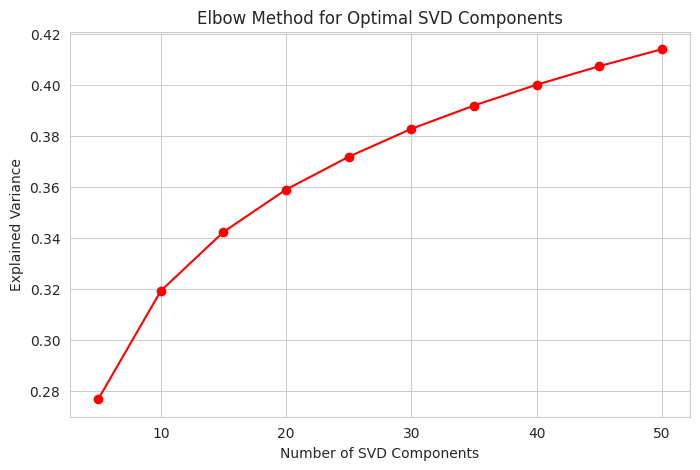

In [ ]:
explained_variance = []
components = range(5, 51, 5)
for n in components:
    svd_test = TruncatedSVD(n_components=n, random_state=42)
    svd_test.fit(ratings_matrix)
    explained_variance.append(sum(svd_test.explained_variance_ratio_))

plt.figure(figsize=(8, 5))
plt.plot(components, explained_variance, marker='o', linestyle='-', color='red')
plt.xlabel("Number of SVD Components")
plt.ylabel("Explained Variance")
plt.title("Elbow Method for Optimal SVD Components")
plt.show()

In [45]:
svd = TruncatedSVD(n_components=20, random_state=42)
collab_features = svd.fit_transform(ratings_matrix)

scaler_cf = StandardScaler()
collab_features = scaler_cf.fit_transform(collab_features)

In [46]:
feature_matrix = np.hstack([content_features, collab_features])

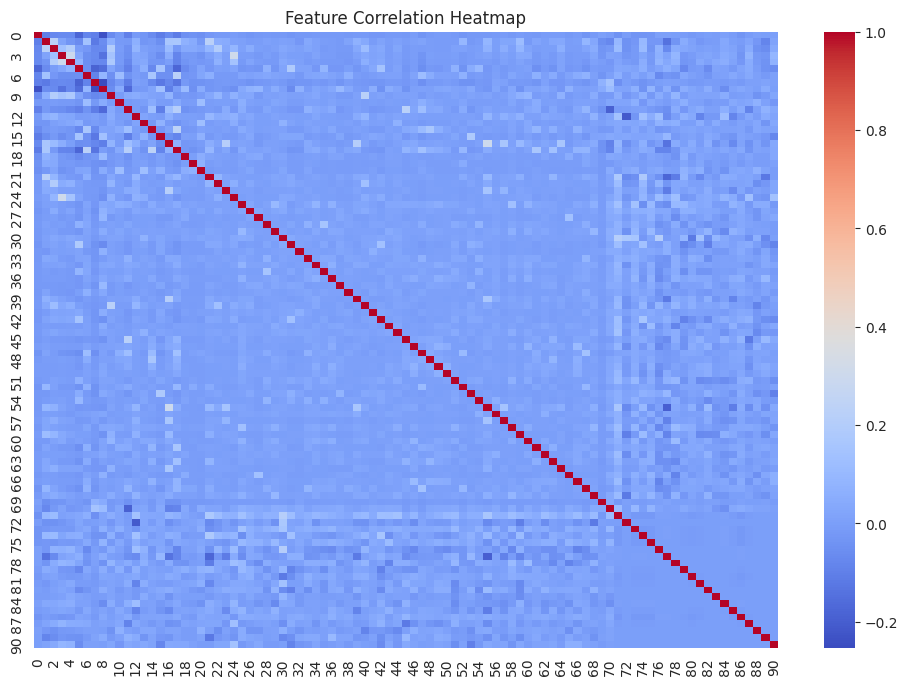

In [ ]:
correlation_matrix = pd.DataFrame(feature_matrix).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [47]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1)
knn_model.fit(feature_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [48]:
final_df = movies_final_df[['movieId', 'title', 'poster_path', 'genres']]

In [49]:
num_movies = movies_final_df.shape[0]
print(f"Total number of movies in the dataset: {num_movies:,}")

Total number of movies in the dataset: 84,432


In [50]:
movie_id_to_idx = {mid: i for i, mid in enumerate(movie_ids)}

movie_id = 1
m_idx = movie_id_to_idx[movie_id]
distances, indices = knn_model.kneighbors(feature_matrix[m_idx].reshape(1, -1), n_neighbors=11)
neighbor_indices = indices.flatten()[1:]
recommended_movie_ids = movie_ids[neighbor_indices]
recommended_titles = final_df[final_df['movieId'].isin(recommended_movie_ids)]['title'].tolist()

In [55]:
print(f"Recommended movies for movie ID {movie_id}")
recommended_titles

Recommended movies for movie ID 1


['Lion King, The (1994)',
 'James and the Giant Peach (1996)',
 'Space Jam (1996)',
 'Twister (1996)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Hunchback of Notre Dame, The (1996)',
 'Willy Wonka & the Chocolate Factory (1971)',
 "Bug's Life, A (1998)",
 'Toy Story 2 (1999)',
 'Toy Story 3 (2010)']

In [56]:
n_components = 20

collab_features_original = scaler_cf.inverse_transform(feature_matrix[:, -n_components:])
user_factors = svd.components_.T
user_ids = ratings_df['userId'].unique()
user_id_to_idx = {uid: i for i, uid in enumerate(user_ids)}

In [57]:
errors = []
for _, row in ratings_df.iterrows():
    movie_id = row['movieId']
    user_id = row['userId']
    actual_rating = row['rating']
    if movie_id in movie_id_to_idx and user_id in user_id_to_idx:
        m_idx = movie_id_to_idx[movie_id]
        u_idx = user_id_to_idx[user_id]
        predicted_rating = collab_features_original[m_idx] @ user_factors[u_idx]
        errors.append(predicted_rating - actual_rating)
errors = np.array(errors)
rmse = np.sqrt(np.mean(errors**2))
mae = np.mean(np.abs(errors))

In [58]:
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 2.6157974904514254
MAE: 2.3156785357593366


In [63]:
save_dict = {
    'df': final_df,
    'feature_matrix': feature_matrix,
    'knn_model': knn_model,
    'movie_ids': movie_ids,
    'svd': svd,
    'scaler_cf': scaler_cf,
    'scaler_avg': scaler_avg,
    'mlb': mlb
}
joblib.dump(save_dict, '/content/drive/MyDrive/DATA/recommender_model.joblib', compress=('zlib', 3))

['/content/drive/MyDrive/DATA/recommender_model.joblib']

In [64]:
file_size = os.path.getsize('/content/drive/MyDrive/DATA/recommender_model.joblib') / (1024 * 1024)
print(f"Saved model file size: {file_size:.2f} MB")

Saved model file size: 61.39 MB
